In [1]:
import warnings
warnings.filterwarnings("ignore")
import ftfy
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re

from math import exp
from numpy import sign

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk import PorterStemmer

from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D, GRU, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model

In [2]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

df = pd.read_csv('../Dataset/sentiment_tweets/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [3]:
df['target'] = df['target'].replace(4, 1)

In [4]:
df_0 = df[df['target'] == 0]
df_1 = df[df['target'] == 1]
df_new = pd.concat([df_0[:25000], df_1[:25000]])

In [5]:
# 0: NEGATIVE
# 4: POSITIVE

from collections import Counter
print(Counter(df_new['target']))

Counter({0: 25000, 1: 25000})


In [6]:
df_new

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
824995,1,1556381057,Sat Apr 18 22:37:08 PDT 2009,NO_QUERY,ethanattack,Yup. Going to sleep. Night guys.
824996,1,1556381076,Sat Apr 18 22:37:06 PDT 2009,NO_QUERY,GinaLaGuardia,"@MsUnitedStates Thank you so, so, so, so much ..."
824997,1,1556381131,Sat Apr 18 22:37:09 PDT 2009,NO_QUERY,CarolCalazans,@tommcfly Hey Tom How are you? http://twitpic....
824998,1,1556381147,Sat Apr 18 22:37:07 PDT 2009,NO_QUERY,KKVegas,Teasing and Mack 1-0 are taking Vegas by storm...


In [7]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
from sklearn.model_selection import train_test_split

X = df_train['text'].values
y = df_train['target'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
EMBEDDING_FILE = 'wiki-news-300d-1M.vec'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=False)

In [10]:
import nltk
# Uncomment to download "stopwords"
#nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

In [ ]:
import re

# Preprocess text
X_train_preprocessed = [text_preprocessing(text) for text in X_train]
X_val_preprocessed = [text_preprocessing(text) for text in X_val]

In [12]:
X_test_preprocessed = [text_preprocessing(text) for text in df_test['text'].values]

In [13]:
import pickle
with open('X_train_preprocessed.pickle', 'wb') as train:
    pickle.dump(X_train_preprocessed, train)
    
with open('X_val_preprocessed.pickle', 'wb') as val:
    pickle.dump(X_val_preprocessed, val)
    
with open('X_test_preprocessed.pickle', 'wb') as test:
    pickle.dump(X_test_preprocessed, test)

In [11]:
import pickle
with open('X_train_preprocessed.pickle', 'rb') as train:
    X_train_preprocessed = pickle.load(train)

with open('X_val_preprocessed.pickle', 'rb') as val:
    X_val_preprocessed = pickle.load(val)

with open('X_test_preprocessed.pickle', 'rb') as test:
    X_test_preprocessed = pickle.load(test)

In [12]:
X_train_preprocessed

['ahh closed',
 'awesome lunch w mom amp bro yummy sushi amp udon',
 'imisscath imisscath imisscath imisscath imisscath imisscath imisscath imisscath imisscath imisscath imisscath imisscath',
 'good morning beautiful one',
 'cracked open first chapter something old new today time beddd nite twitter',
 'nothank sorry spoken loud possible esp stranger esp india',
 'yeah add code catch exceptions violate not allow code violate',
 'meds futile ibs symptoms possibly worse last week want mc',
 'kobe not player team kobe kobe kobe maybe get rid players jus let kobe play',
 'not need prestige need find satisfaction within lt 3',
 'photographyclass not much happening retouching photo african wilddog',
 'well thats always good sign',
 'http twitpic com 7kf4b yaaay pre ordered mine know learned ? postal delivery sucks u g',
 'great day sunny warm think go jogging w dog afternoon good day everyone',
 'nope',
 'think reminder',
 'blah monday',
 'good news morning got job wooooohoooooo',
 'didnt ent

In [13]:
MAX_NB_WORDS = 20000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train_preprocessed + X_val_preprocessed)

sequences_train = tokenizer.texts_to_sequences(X_train_preprocessed)
sequences_val = tokenizer.texts_to_sequences(X_val_preprocessed)
sequences_test = tokenizer.texts_to_sequences(X_test_preprocessed)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 303656 unique tokens


In [14]:
MAX_SEQUENCE_LENGTH = 140
data_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
data_val = pad_sequences(sequences_val, maxlen=MAX_SEQUENCE_LENGTH)
data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data_train.shape)

Shape of data tensor: (1024000, 140)


In [15]:
EMBEDDING_DIM = 300
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((len(word_index), EMBEDDING_DIM))

In [16]:
for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < len(word_index):
        embedding_matrix[idx] = word2vec.word_vec(word)

In [17]:
print(embedding_matrix)
print(embedding_matrix.shape)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.0157     -0.0748     -0.0862     ...  0.189      -0.0433
  -0.1014    ]
 [-0.1208      0.0144     -0.0927     ...  0.28290001  0.0629
   0.0723    ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.1069      0.0121     -0.0426     ... -0.0327      0.0704
   0.0589    ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(303656, 300)


In [18]:
# Assigning labels to the depressive tweets and random tweets data
#labels_train = df_train[' Label'].values
#labels_val = df_val[' Label'].values
y_test = df_test['target'].values

In [19]:
print(data_train)
print(data_val)
print(data_test)
print(y_train)
print(y_val)
print(y_test)

[[    0     0     0 ...     0   602  1031]
 [    0     0     0 ...   760  1336    24]
 [    0     0     0 ... 10941 10941 10941]
 ...
 [    0     0     0 ...  1817   718 12899]
 [    0     0     0 ...    50   222    26]
 [    0     0     0 ...   116  2611   708]]
[[    0     0     0 ...     9    60   124]
 [    0     0     0 ...    78   789   746]
 [    0     0     0 ...   319     1    29]
 ...
 [    0     0     0 ...   283  1678    37]
 [    0     0     0 ... 19663   711  2026]
 [    0     0     0 ...   166     7   143]]
[[   0    0    0 ...  705   42  103]
 [   0    0    0 ...  138 1434   28]
 [   0    0    0 ...  301  229   18]
 ...
 [   0    0    0 ...   34  463 4376]
 [   0    0    0 ...   99  104  137]
 [   0    0    0 ... 1557  604  463]]
[0 1 0 ... 0 1 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 1 1 0]


In [20]:
from keras import backend as K 

# Do some code, e.g. train and save model

K.clear_session()

In [21]:
import tensorflow as tf
with tf.device('/device:GPU:1'):
    model = Sequential()
    # Embedded layer
    model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    # Convolutional Layer
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    #model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.2))
    #model.add(Dense(10, activation='relu'))
    # LSTM Layer
    model.add(LSTM(300))
    #model.add(GRU(300))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
    print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 300)          91096800  
_________________________________________________________________
conv1d (Conv1D)              (None, 140, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 70, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 70, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 300)               399600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
#reduce_lr_on_plateau_cb = ReduceLROnPlateau(verbose = 1, factor=0.1, patience=2)

with tf.device('/device:GPU:1'):
    hist = model.fit(data_train, y_train, validation_data=(data_val, y_val), epochs=5, batch_size=32, shuffle=True, callbacks=[early_stop])

Epoch 1/5
32000/32000 [==============================] - 305s 10ms/step - loss: 0.4641 - acc: 0.7801 - val_loss: 0.4409 - val_acc: 0.7946
Epoch 2/5
32000/32000 [==============================] - 304s 10ms/step - loss: 0.4444 - acc: 0.7923 - val_loss: 0.4358 - val_acc: 0.7972
Epoch 3/5
32000/32000 [==============================] - 301s 9ms/step - loss: 0.4378 - acc: 0.7958 - val_loss: 0.4320 - val_acc: 0.7986
Epoch 4/5
32000/32000 [==============================] - 306s 10ms/step - loss: 0.4333 - acc: 0.7983 - val_loss: 0.4299 - val_acc: 0.8003
Epoch 5/5
32000/32000 [==============================] - 305s 10ms/step - loss: 0.4306 - acc: 0.8002 - val_loss: 0.4301 - val_acc: 0.8013


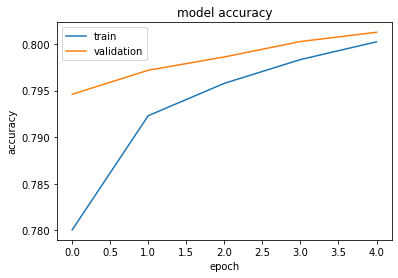

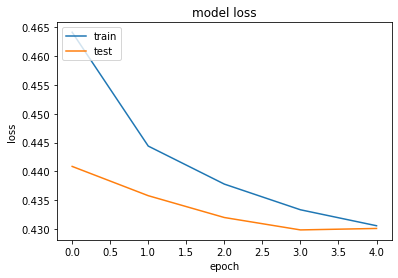

In [23]:
#plot_model(model, to_file='model.png')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

with tf.device('/device:GPU:1'):
    labels_pred = model.predict(data_test)
    labels_pred = np.round(labels_pred.flatten())
    accuracy = accuracy_score(y_test, labels_pred)
    f1 = f1_score(y_test, labels_pred, average='weighted')

    print("Accuracy: %.2f%%" % (accuracy*100))
    print("F1 Score: %.2f" % (f1*100))

    print(classification_report(y_test, labels_pred))

Accuracy: 80.07%
F1 Score: 80.06
              precision    recall  f1-score   support

           0       0.81      0.79      0.80    159494
           1       0.80      0.81      0.80    160506

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



In [25]:
model.save('model/word2vec_CNN_LSTM-Sentiment.h5')

In [21]:
import tensorflow as tf
with tf.device('/device:GPU:1'):
    model2 = Sequential()
    # Embedded layer
    model2.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    # Convolutional Layer
    #model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    #model.add(GlobalAveragePooling1D())
    #model.add(Dropout(0.2))
    #model.add(Dense(10, activation='relu'))
    # LSTM Layer
    model2.add(LSTM(300))
    #model.add(GRU(300))
    model2.add(Dropout(0.2))
    model2.add(Dense(1, activation='sigmoid'))

    model2.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
    print(model2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 300)          91096800  
_________________________________________________________________
lstm (LSTM)                  (None, 300)               721200    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
Total params: 91,818,301
Trainable params: 721,501
Non-trainable params: 91,096,800
_________________________________________________________________
None


In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
#reduce_lr_on_plateau_cb = ReduceLROnPlateau(verbose = 1, factor=0.1, patience=2)

with tf.device('/device:GPU:1'):
    hist = model2.fit(data_train, y_train, validation_data=(data_val, y_val), epochs=5, batch_size=32, shuffle=True, callbacks=[early_stop])

Epoch 1/5
32000/32000 [==============================] - 386s 12ms/step - loss: 0.4534 - acc: 0.7865 - val_loss: 0.4296 - val_acc: 0.8014
Epoch 2/5
32000/32000 [==============================] - 385s 12ms/step - loss: 0.4194 - acc: 0.8063 - val_loss: 0.4166 - val_acc: 0.8090
Epoch 3/5
32000/32000 [==============================] - 384s 12ms/step - loss: 0.4011 - acc: 0.8162 - val_loss: 0.4123 - val_acc: 0.8111
Epoch 4/5
32000/32000 [==============================] - 385s 12ms/step - loss: 0.3827 - acc: 0.8257 - val_loss: 0.4122 - val_acc: 0.8128
Epoch 5/5
32000/32000 [==============================] - 385s 12ms/step - loss: 0.3618 - acc: 0.8361 - val_loss: 0.4193 - val_acc: 0.8102


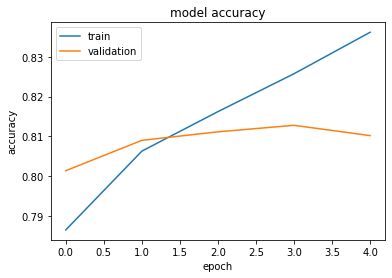

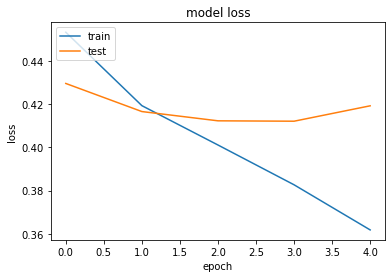

In [23]:
#plot_model(model, to_file='model.png')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score, f1_score

with tf.device('/device:GPU:1'):
    labels_pred = model2.predict(data_test)
    labels_pred = np.round(labels_pred.flatten())
    accuracy = accuracy_score(y_test, labels_pred)
    f1 = f1_score(y_test, labels_pred, average='weighted')

    print("Accuracy: %.2f%%" % (accuracy*100))
    print("F1 Score: %.2f" % (f1*100))

    print(classification_report(y_test, labels_pred))

Accuracy: 80.87%
F1 Score: 80.86
              precision    recall  f1-score   support

           0       0.82      0.79      0.80    159494
           1       0.80      0.83      0.81    160506

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



In [25]:
model2.save('model/word2vec_LSTM-Sentiment.h5')

In [26]:
import tensorflow as tf
with tf.device('/device:GPU:1'):
    model3 = Sequential()
    # Embedded layer
    model3.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    # Convolutional Layer
    #model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    #model.add(GlobalAveragePooling1D())
    #model.add(Dropout(0.2))
    #model.add(Dense(10, activation='relu'))
    # LSTM Layer
    model3.add(Bidirectional(LSTM(300)))
    #model.add(GRU(300))
    model3.add(Dropout(0.2))
    model3.add(Dense(1, activation='sigmoid'))

    model3.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
    print(model3.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 300)          91096800  
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               1442400   
_________________________________________________________________
dropout_1 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 601       
Total params: 92,539,801
Trainable params: 1,443,001
Non-trainable params: 91,096,800
_________________________________________________________________
None


In [27]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
#reduce_lr_on_plateau_cb = ReduceLROnPlateau(verbose = 1, factor=0.1, patience=2)

with tf.device('/device:GPU:1'):
    hist = model3.fit(data_train, y_train, validation_data=(data_val, y_val), epochs=5, batch_size=32, shuffle=True, callbacks=[early_stop])

Epoch 1/5
32000/32000 [==============================] - 672s 21ms/step - loss: 0.4519 - acc: 0.7872 - val_loss: 0.4276 - val_acc: 0.8018
Epoch 2/5
32000/32000 [==============================] - 672s 21ms/step - loss: 0.4183 - acc: 0.8069 - val_loss: 0.4142 - val_acc: 0.8099
Epoch 3/5
32000/32000 [==============================] - 673s 21ms/step - loss: 0.3987 - acc: 0.8178 - val_loss: 0.4122 - val_acc: 0.8121
Epoch 4/5
32000/32000 [==============================] - 673s 21ms/step - loss: 0.3793 - acc: 0.8276 - val_loss: 0.4137 - val_acc: 0.8114
Epoch 5/5
32000/32000 [==============================] - 673s 21ms/step - loss: 0.3575 - acc: 0.8385 - val_loss: 0.4194 - val_acc: 0.8101


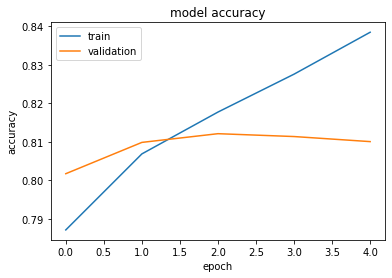

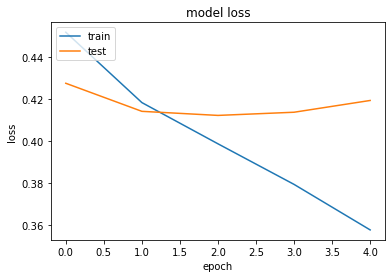

In [28]:
#plot_model(model, to_file='model.png')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

with tf.device('/device:GPU:1'):
    labels_pred = model3.predict(data_test)
    labels_pred = np.round(labels_pred.flatten())
    accuracy = accuracy_score(y_test, labels_pred)
    f1 = f1_score(y_test, labels_pred, average='weighted')

    print("Accuracy: %.2f%%" % (accuracy*100))
    print("F1 Score: %.2f" % (f1*100))

    print(classification_report(y_test, labels_pred))

Accuracy: 80.88%
F1 Score: 80.88
              precision    recall  f1-score   support

           0       0.81      0.81      0.81    159494
           1       0.81      0.81      0.81    160506

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



In [30]:
model3.save('model/word2vec_BiLSTM-Sentiment.h5')